In [1]:
import sys
sys.path.append("../")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
import pandas as pd

from experiments import RandomWalkDiffusionExperiment
from models import RandomWalkDiffusion
from likelihoods import sample_random_walk_diffusion_process

/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
FIT_MODEL = False
POSTERIOR_RESIMULATION = False

N_SAMPLES = 2000
N_RESIM = 200

LOCAL_PARAM_LABELS = ['Drift rate', 'Drift rate', 'Threshold', 'Non-decision time', 'Bias']
LOCAL_PARAM_NAMES  = [r'v_1', r'v_2', r'a', r'\tau', r'\beta']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 12

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

# Neural Experiment

In [3]:
model = RandomWalkDiffusion()
neural_experiment = RandomWalkDiffusionExperiment(model)

INFO:root:Performing 2 pilot runs with the random_walk_diffusion_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 112, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 112)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 112, 5)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/yes_no_task/history_50.pkl.
INFO:root:Networks loaded from ../checkpoints/yes_no_ta

## Training

In [4]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=50, 
        iterations_per_epoch=1000, 
        batch_size=32
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

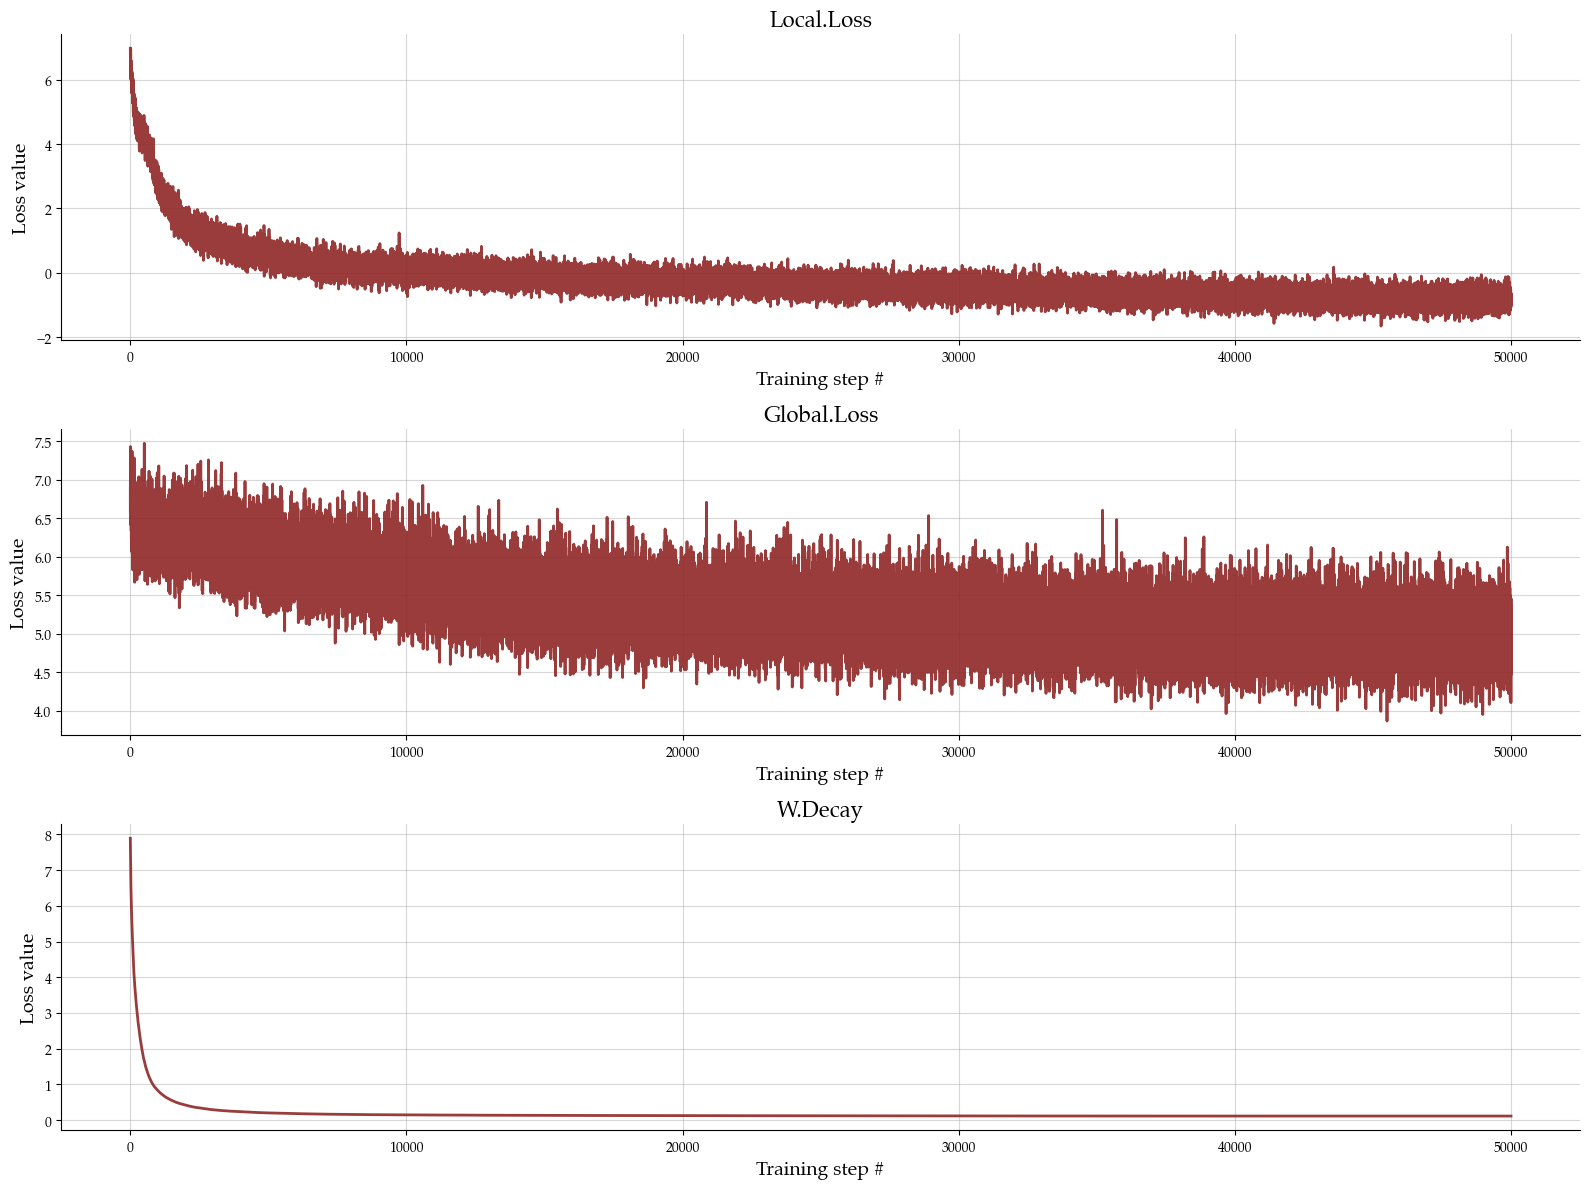

In [5]:
f = beef.diagnostics.plot_losses(history)

In [6]:
data = pd.read_csv("../data/yes_no_data_picture.csv")
data["rt"][data["new_resp"] == 1] = -data["rt"][data["new_resp"] == 1]
N_OBS = 112
N_SUB = len(np.unique(data['id']))

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_20808/45531790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["rt"][data["new_resp"] == 1] = -data["rt"][data["new_resp"] == 1]


In [7]:
if FIT_MODEL:
    post_samples = np.full((N_SUB, N_OBS, N_SAMPLES, 5), np.nan)
    with tf.device('/cpu:0'):
        for i in range(N_SUB):
            person_data = data[data['id'] == i+1]
            rt = person_data['rt'].to_numpy()
            context = person_data['new_item'].to_numpy()
            mask = np.isfinite(rt)
            person_data = np.c_[rt, context]
            person_data = person_data[mask, :]
            tmp_data = {'summary_conditions': person_data[None, :, :]}
            samples = neural_experiment.amortizer.sample(tmp_data, N_SAMPLES)['local_samples']
            post_samples[i, mask, :, :] = samples
        np.save("../data/posterior_samples_pictures.npy", post_samples)
else:
    post_samples = np.load("../data/posterior_samples_pictures.npy")

In [8]:
post_samples_not_z = post_samples * model.local_prior_stds + model.local_prior_means
post_means = np.nanmean(post_samples_not_z, axis=2)
post_std = np.nanstd(post_samples_not_z, axis=2)
post_means_mean = np.nanmean(post_means, axis=0)
post_means_std = np.nanstd(post_means, axis=0)
np.save("../data/posterior_means.npy", post_means)

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_20808/3296526388.py:2: RuntimeWarning: Mean of empty slice
  post_means = np.nanmean(post_samples_not_z, axis=2)
/Users/lukas/opt/miniconda3/envs/bfPower/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


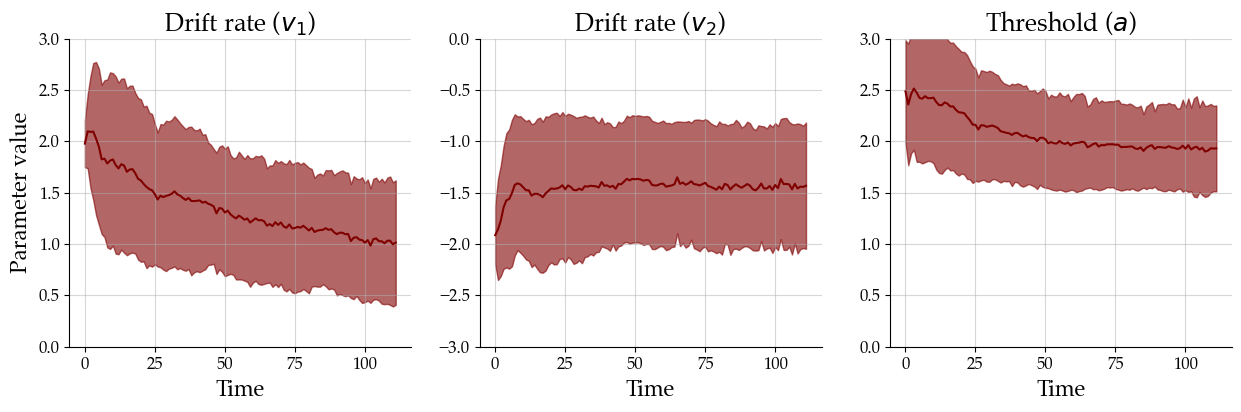

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        range(N_OBS), post_means_mean[:, i],
        color='maroon'
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.6
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)

    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0 or i == 2:
        ax.set_ylim([0.0, 3.0])
    if i ==1 :

        ax.set_ylim([-3.0, 0.0])
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
f.tight_layout()
plt.savefig('../plots/parameter_dynamic_1.png', dpi=300)

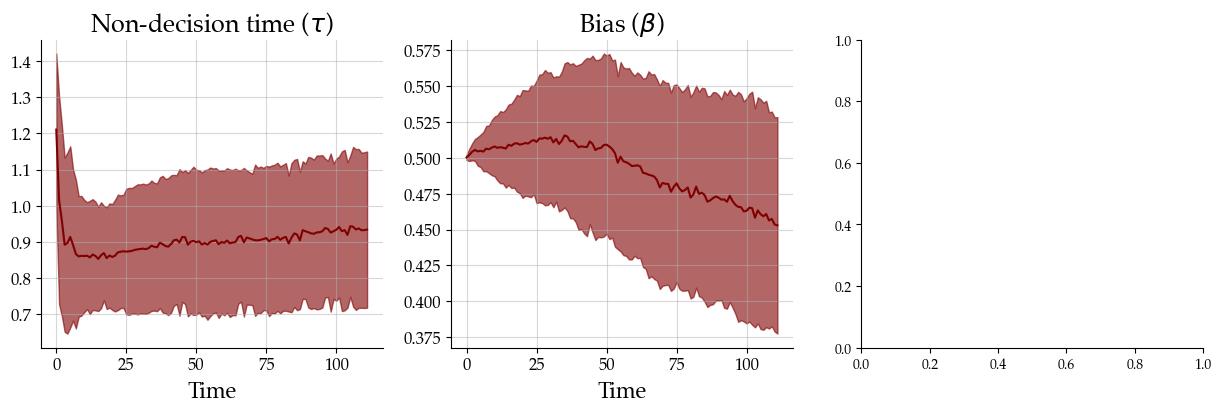

In [10]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axarr.flat):
    if i == 2:
        break
    ax.grid(alpha=0.5)
    ax.plot(
        range(N_OBS), post_means_mean[:, i+3],
        color='maroon'
    )
    ax.fill_between(
        range(N_OBS),
        post_means_mean[:, i+3] - post_means_std[:, i+3],
        post_means_mean[:, i+3] + post_means_std[:, i+3],
        color='maroon', alpha=0.6
    )
    ax.set_title(f'{LOCAL_PARAM_LABELS[i+3]} (${LOCAL_PARAM_NAMES[i+3]}$)', fontsize=FONT_SIZE_1)

    
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i+3 == 0 or i+3 == 2:
        ax.set_ylim([0.0, 3.0])
    if i+3 ==1 :
        ax.set_ylim([-3.0, 0.0])
    if i+3 == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time", fontsize=FONT_SIZE_2)

sns.despine()
# f.tight_layout()

plt.savefig('../plots/parameter_dynamic_2.png', dpi=300)

## Posterior resimulation

In [11]:
if POSTERIOR_RESIMULATION:
    pred_data = np.zeros((N_RESIM, N_SUB, N_OBS, 1))
    for s in range(N_SUB):
        post_idx = np.random.choice(np.arange(N_SAMPLES), N_RESIM)
        person_data = data[data['id'] == s+1]
        context = person_data['new_item'].to_numpy()
        for i in range(N_RESIM):
            idx = post_idx[i]
            pred_data[i, s] = sample_random_walk_diffusion_process(post_samples_not_z[s, :, idx], context)[:, None]
    np.save("../data/posterior_resimulation_hehe_hetero.npy", pred_data)
else:
    pred_data = np.load("../data/posterior_resimulation_pictures.npy")